##                                    Recipe Recommender

SUMMARY

    #Back Story#
Your friend has a startup idea – they want to start a food social network. To begin with, they want to make an app that recommends recipes based on what is in a person’s grocery cart. You agreed to help your friend design a proof of concept recipe recommender.


Data Source : - https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions?select=RAW_recipes.csv

In the dataset we have all the recipes and ingredients details. The list of ingredients is used as the "Grocery Cart" items and the associated "Name" as recipe.

#### Steps Involved
1. Analyzing the dataset confirms that both recipe name and ingredients (items) list are present in the dataset.
2. The Topic model (LDA) approach is used to classify ingredients (items) in a grocery cart to a particular recipe.
3. The list of items are extracted from the inner list and then tokenized by nltk library for processing.
4. Frequencies of items are plotted for understanding frequently ordered items and Vectors are created accordingly.
5. Conversion of Sparse Matrix to gensim corpus and word id's are mapped to words.
6. Once the data is processed then Similarity score is calculated and LDA model is trained with corpus.
7. The 'query' variable contains the list of grocery items and is processed to get similar recipe.
8. There is a wide scope to design recommender system and here gensim.lda topic modeling is used.


In [1]:
# Importing Required Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
import nltk
from collections import Counter
import gensim
import random
from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.models.ldamodel import LdaModel
from gensim import models, similarities
from gensim.corpora import Dictionary


import warnings
warnings.filterwarnings('ignore')

seed = 0

In [2]:
# Reading the CSV file

df = pd.read_csv(r'recipes.csv')

In [9]:
# All the required columns are present in the dataset

df.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13


In [7]:
# Checking the Null Values

df.isnull().sum()

name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64

In [10]:
# A function to extract items from the inner list in Ingredients column

def treat_ingredients(input):
    
    output = []
    for ingredient in eval(input):
        ingredient_list = ingredient.split(' ')
        output.append("_".join(ingredient_list))
    return " ".join(output)

In [11]:
# Convert items to the required format 

ingredients_all = df.ingredients.apply(lambda x: treat_ingredients(x))

In [13]:
# Corpus to tokenize the items

ingredients_corpus = " ".join(list(ingredients_all))

In [16]:
# Sample Corpus

ingredients_corpus[:50]

'winter_squash mexican_seasoning mixed_spice honey '

In [17]:
# Tokenization using nltk library

ingredients_corpus = nltk.Text(nltk.word_tokenize(ingredients_corpus))

In [20]:
# Sample corpus after tokenization

ingredients_corpus[:5]

['winter_squash', 'mexican_seasoning', 'mixed_spice', 'honey', 'butter']

In [21]:
# Frequency is calculated for each word(item)

ingre_dist = FreqDist(ingredients_corpus)

In [23]:
# Sample FreqDist

ingre_dist

FreqDist({'salt': 42, 'onion': 24, 'butter': 21, 'eggs': 21, 'water': 17, 'sugar': 17, 'milk': 14, 'garlic': 14, 'brown_sugar': 12, 'flour': 12, ...})

In [24]:
# Extracting the dictionary keys into list

ing_key =  list(ingre_dist.keys())

In [25]:
# Create (ingredient name, frequency) tupples for further process

ing_freq = []

for key in ing_key:
    ing_freq.append((key,ingre_dist[key]))



In [28]:
# Sample (ingredient name, frequency) tupples

ing_freq[:5]

[('winter_squash', 1),
 ('mexican_seasoning', 1),
 ('mixed_spice', 1),
 ('honey', 6),
 ('butter', 21)]

In [29]:
# Sorted and reversed the tupples to check the highest frequency 

ing_freq_sorted = sorted(ing_freq,key = lambda x: x[1],reverse = True)

In [36]:
# Created a new DataFrame with Item's Tag and Frequency 

df_ing = pd.DataFrame(ing_freq_sorted[:20], columns =['item_names', 'Frequency']) 

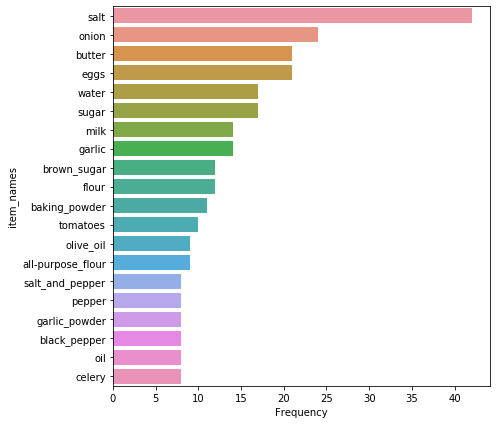

In [38]:
# Plotting the most frequenstly item purchased from the grocery Store.

f, ax = plt.subplots(figsize=(7, 6))
sns.barplot(x="Frequency", y="item_names", data=df_ing,ax = ax)
plt.tight_layout()
plt.savefig('output/most_freq_ing.png')

In [41]:
# Using the preprocessed list of items

ingredients_all[-5:]

95    butter sugar eggs bananas water baking_soda sa...
96    oreo_cookie_crumbs butter cream_cheese sweeten...
97    banana natural-style_peanut_butter 2%_low-fat_...
98    cream_cheese sour_cream taco_seasoning bean_di...
99    mccormick's_montreal_brand_steak_seasoning dil...
Name: ingredients, dtype: object

In [63]:
# Get the similarity Index 

def get_similarity(lda, query_vector):
    index = similarities.MatrixSimilarity(lda[corpus])
    sims = index[query_vector]
    return sims


In [52]:
# It changes to array of unicode tokens

def treat_ingredients(ing_list):
    output = []
    for ingredient in ing_list:
        ingredient_list = ingredient.split(' ')
        output.append("_".join(ingredient_list))
    return output

In [73]:
# This function includes all the preprocessing steps and Training on LDA model

def train_lda_model(ingredients,num_topics,passes = 15,random_state = seed):
    
    # Get the list of transformed ingredients    
    ingredients_all = ingredients.apply(lambda x: treat_ingredients(x))
    
    # Dictionary (for Gensim vectorizer)    
    dictionary = Dictionary([ing for ing in list(ingredients_all)])
    
    # build corpus: BOW(Bag Of Words)    
    corpus = [dictionary.doc2bow(text) for text in list(ingredients_all)]
    
    # Training of lda model
    ldamodel = LdaModel(corpus,num_topics = num_topics, passes = passes,random_state = random_state, id2word = dictionary)
    
    return ldamodel,dictionary,corpus

In [57]:
# treat input function, returning a list of tokenized ingredients

def treat_words (words):
    list_words = words.split(",")
    output = []
    for w in list_words:
        output.append("_".join(w.strip().split(" ")))
    return output

In [43]:
# The list of Grocery items(query) and ldaModel along dictionary are passed to return similarity score

def calculate_similarity(query,ldamodel,dct):
    
    # Process input words
    # doc2bow :- converts the word to its integer word id and returns Sparse Matrix
    words_bow = dct.doc2bow(treat_words(query))
    query_vector = ldamodel[words_bow]
    
    # Calculate ranking
    sim_rank = get_similarity(lda = ldamodel, query_vector = query_vector)
    sim_rank = sorted(enumerate(sim_rank), key=lambda item: -item[1])
    
    return sim_rank

In [44]:
# This function uses similarity rank to return the recommendations

def calculate_recommendation(sim_rank,groups,n_reco = 10):
    results = [sim_rank[0][0]]
    results_prob = [sim_rank[0][1]]
    result_group = [sim_rank[0][1]]
        
    for recipe,group in zip(sim_rank[1:],groups[1:]):
        if group not in set(result_group):
            results.append(recipe[0])
            result_group.append(group)
            results_prob.append(recipe[1])
        if len(results) == n_reco:
            break
    print(result_group,"\n",results_prob)
    return results

In [59]:
# This is a wrapper function for calculate simu and calculate reco

def get_similarity_reco (query,ldamodel,dct,corpus,n_reco = 10):
    
    # Calculate rank
    sim_rank = calculate_similarity(query,ldamodel,dct)
    
    # Find groups according to lda model
    groups = []
    for l in ldamodel[corpus]:
        try:
            groups.append(l[0][0])
        except:
            groups.append(random.randint(1, 100))
            
    return calculate_recommendation(sim_rank,groups,n_reco)

In [75]:
# It takes the indexes input and returns the recommended rows as result.

def print_reco(results):
    results = sorted(results)
    return df.iloc[results]

In [47]:
# This fucntion formats the Name

def pretty_name (name):
    return " ".join([ word.capitalize() for word in name.split(" ") if word != ""])

In [74]:
# Number of Topics is passed as 100. The algo will try to recommend options from different groups.
# So that users have different recommendation.

ldamodel,dictionary,corpus = train_lda_model(df['ingredients'],100)

### Pass the list of items in the 'Items' variable for Recommendation

Select any of the below list of items to check recommendation. Comment all other items list. Users can also enter their choice of Items .

In [83]:
# List of Items to be Passed for Recommendation


Items = 'Butter Madeira Cake, Cheese Rolls, Chicken Breasts Saltimbocca, Swiss Crab Melt'

# Items = 'ripe_olives,perpercorn, pepper, salt'
# Items = 'oil, bread, egg, mustard'

In [76]:
# It stores the indexes of rows which has high Similarity score

results = get_similarity_reco (Items, ldamodel, dct = dictionary, corpus = corpus,n_reco = 10)

[0.0, 11, 40, 75, 79, 37, 42, 6, 22, 58] 
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [79]:
# This returns the dataframe with all the recommended columns

recom_recipes = print_reco(results)

#### List of Top 10 recipes recommended 

In [80]:
recom_recipes['name']

0     arriba   baked winter squash mexican style
1               a bit different  breakfast pizza
2                      all in the kitchen  chili
3                             alouette  potatoes
4             amish  tomato ketchup  for canning
5                        apple a day  milk shake
6                          aww  marinated olives
7                 backyard style  barbecued ribs
9                        beat this  banana bread
10                   berry  good sandwich spread
Name: name, dtype: object

In [82]:
# List of predicted recipes with the Items

recom_recipes[['name','ingredients']].style.set_properties(subset=['ingredients'], **{'width': '500px'})

,name,ingredients
0,arriba baked winter squash mexican style,"['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']"
1,a bit different breakfast pizza,"['prepared pizza crust', 'sausage patty', 'eggs', 'milk', 'salt and pepper', 'cheese']"
2,all in the kitchen chili,"['ground beef', 'yellow onions', 'diced tomatoes', 'tomato paste', 'tomato soup', 'rotel tomatoes', 'kidney beans', 'water', 'chili powder', 'ground cumin', 'salt', 'lettuce', 'cheddar cheese']"
3,alouette potatoes,"['spreadable cheese with garlic and herbs', 'new potatoes', 'shallots', 'parsley', 'tarragon', 'olive oil', 'red wine vinegar', 'salt', 'pepper', 'red bell pepper', 'yellow bell pepper']"
4,amish tomato ketchup for canning,"['tomato juice', 'apple cider vinegar', 'sugar', 'salt', 'pepper', 'clove oil', 'cinnamon oil', 'dry mustard']"
5,apple a day milk shake,"['milk', 'vanilla ice cream', 'frozen apple juice concentrate', 'apple']"
6,aww marinated olives,"['fennel seeds', 'green olives', 'ripe olives', 'garlic', 'peppercorn', 'orange rind', 'orange juice', 'red chile', 'extra virgin olive oil']"
7,backyard style barbecued ribs,"['pork spareribs', 'soy sauce', 'fresh garlic', 'fresh ginger', 'chili powder', 'fresh coarse ground black pepper', 'salt', 'fresh cilantro leaves', 'tomato sauce', 'brown sugar', 'yellow onion', 'white vinegar', 'honey', 'a.1. original sauce', 'liquid smoke', 'cracked black pepper', 'cumin', 'dry mustard', 'cinnamon sticks', 'orange, juice of', 'mirin', 'water']"
9,beat this banana bread,"['sugar', 'unsalted butter', 'bananas', 'eggs', 'fresh lemon juice', 'orange rind', 'cake flour', 'baking soda', 'salt']"
10,berry good sandwich spread,"['whole berry cranberry sauce', 'sour cream', 'prepared horseradish']"
